# COAP between FIT and Grid'5000

Revisiting https://www.iot-lab.info/learn/tutorials/riot/riot-coap-m3/ in the context of mixed G5K/FIT resources.


---
- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib
---



## Prerequisites:

<div class="alert alert-block alert-warning">
    Make sure you've run the one time setup for your environment (e.g one time setup for https://labs.iot-lab.info)
</div>

## Overview

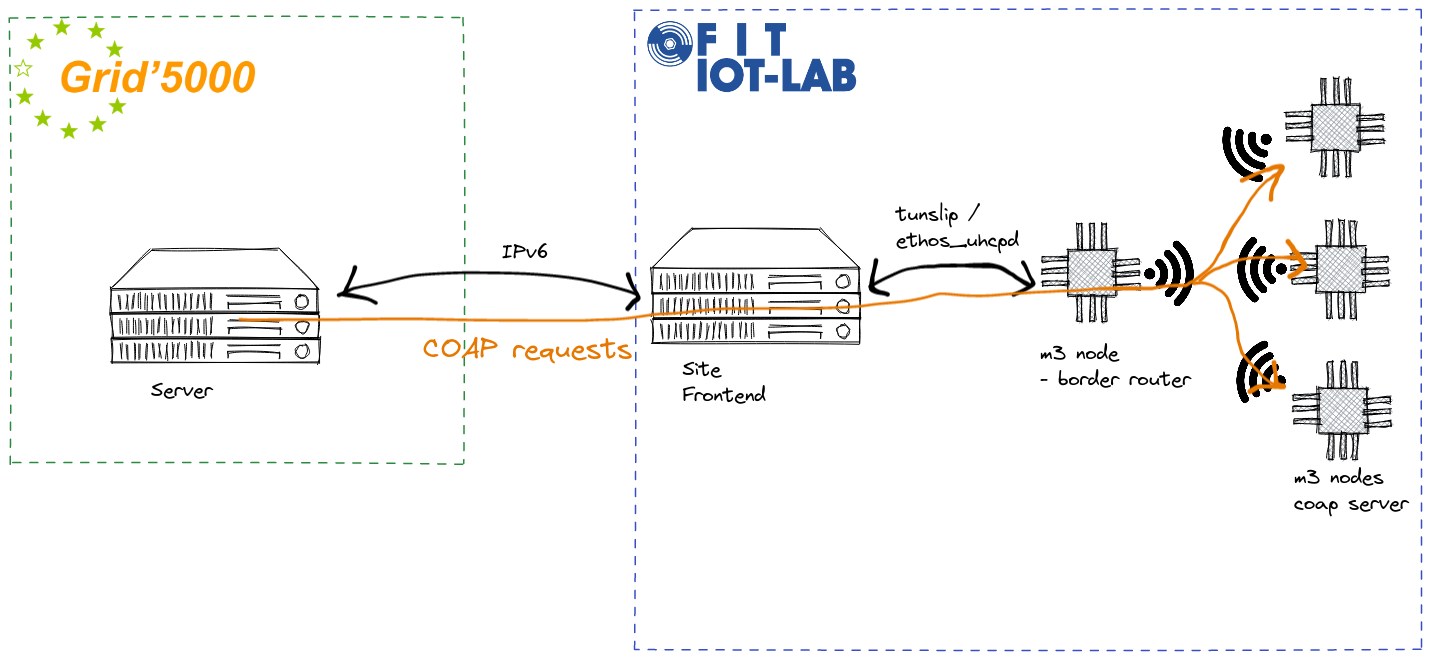


## FIT side

### Firmware compilations

If you are running this training at the same time as other people on the testbed, it is a good idea to change the default radio configuration to avoid too much collision with others.

Use the following cell to give you random values for channel and PAN ID.

In [ ]:
import os,binascii,random
pan_id = binascii.b2a_hex(os.urandom(2)).decode()
channel = random.randint(11, 26)
fit_site = random.choice(["grenoble", "lille"])

print(f"Use FIT_SITE={fit_site}, CHANNEL={channel}, PAN_ID=0x{pan_id}")

In [ ]:
# save the random parameters (allow to restart from here) 
FIT_SITE = CHANGEME!
%env CHANNEL = CHANGEME!
%env PAN_ID = CHANGEME!
%env ETHOS_BAUDRATE = 500000

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/gnrc_border_router
!make -C $APP_DIR BOARD=iotlab-m3 DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/*.bin .

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/nanocoap_server
!make -C $APP_DIR  BOARD=iotlab-m3  DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/nanocoap_server.bin nanocoap_server.bin

### Get some resources

In [ ]:
import enoslib as en

en.init_logging()

In [ ]:
fit_conf = (
    en.IotlabConf.from_settings(job_name="coap_m3", walltime="02:00")
    .add_machine(roles=["border_router"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="gnrc_border_router.bin")    
    .add_machine(roles=["coap"], archi="m3:at86rf231", site=FIT_SITE, number=3, image="nanocoap_server.bin")
)
fit_conf

In [ ]:
fit = en.Iotlab(fit_conf)
fit_roles, _ = fit.init()

In [ ]:
# keep track of the border router
br = fit_roles["border_router"][0]


In [ ]:
# useless at this point but practical in case we need to reflash the nodes
fit.reset()

### Setting up IPv6

In [ ]:
import iotlabcli
iotlab_user, _ = iotlabcli.auth.get_user_credentials()
fit_frontend = en.Host("%s.iot-lab.info" % FIT_SITE, alias=FIT_SITE, user=iotlab_user) 

At this point you need to pick a free tap number and a [free subnet](https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html)  

In [ ]:
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

In [ ]:
# CHANGE ME!
tap = "tap0203"
prefix = "2001:660:4403:0480"

In [ ]:
# Kill any existing ethos_uhcpd process of our own using this tap
en.run(f"ps aux | grep {tap} | grep {iotlab_user}| grep -v grep | awk '{{print $2}}' | xargs -r kill", roles=fit_frontend)

In [ ]:
# Start the ethos_uhcpd process to start bridging wire and wireless network using the m3 node
r = en.run(f"sudo ethos_uhcpd.py {br.alias} {tap} {prefix}::1/64 2>&1 >> ethos_uhcpd.out", roles=fit_frontend, background=True)

In [ ]:
# Check that the route is now used
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

---


In [ ]:
# a bit hacky but should get the coap nodes
# the ip address can be capture on the serial link when the node restarts
# so we spawn a background process that will be around for 10s and write what can be read on the serial link of the m3
# Alternatively the ip of the m3 should appear in the border router interface (but here the connection is busy)
for coap_node in fit_roles["coap"]:
    en.run(f"echo '' | nc -w10 {coap_node.alias} 20000 > {coap_node.alias}.out", roles=fit_frontend, background=True)
    coap_node.reset()

In [ ]:
import re
# find the ipv6 addresses of the coap nodes 
# These are those in the ipv6 prefix found when reading the output on the serial link
coap_servers = []
for coap_node in fit_roles["coap"]:
    # we remove the first lines since there are situation 
    # where we receive surprising caracters on the wire !
    r = en.run(f"cat {coap_node.alias}.out | tail -n 5", roles=fit_frontend)
    print(r[0].stdout)
    m = re.findall(f'inet6 addr: (.*)  scope: global', r[0].stdout)
    if m:
        coap_servers.append(m[0])
coap_servers

## Grid'5000 side

### Get some resources

You can check what's available here: https://www.grid5000.fr/w/Status

Some direct links:
- Gantt for nancy: https://intranet.grid5000.fr/oar/Nancy/drawgantt-svg/
- Gantt for rennes: https://intranet.grid5000.fr/oar/Rennes/drawgantt-svg/
- ...


In [ ]:
network = en.G5kNetworkConf(type="prod", roles=["my_network"], site="nancy")

conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", job_name="coap_client")
    .add_network_conf(network)
    .add_machine(
        roles=["client"], cluster="grisou", nodes=1, primary_network=network
    )
    .finalize()
)
conf

In [ ]:
g5k = en.G5k(conf)
g5k_roles, g5k_networks = g5k.init()
g5k_roles

### Setting up IPv6

In [ ]:
en.run("dhclient -6 br0", g5k_roles)

r = en.run("ip a", g5k_roles)
print(r[0].stdout)

In [ ]:
# Sanity check ping the coap_servers
with en.actions(roles=g5k_roles) as a:
    a.apt(name="fping", state="present")
    a.shell(f"fping6 {' '.join(coap_servers)}", task_name="ping")
print(a.results.filter(task="ping")[0].stdout)

## Generate some load on the fit nodes (and on the radio)

In [ ]:
# Install coap client dependencies
import datetime
import time

# copy load injection python script (and install the required library)
with en.actions(roles=g5k_roles) as p:
    p.pip(name="aiocoap[all]", state="present")
    p.copy(src="read_sensor.py", dest="/tmp/read_sensor.py", mode="0755")

In [ ]:
from pathlib import Path
import time

# send load for DURATION
DURATION = 30

# Wait this amount of time before sending a new coap get
SLEEP_INTERVAL = 1

# Number of coap client per coap node
DENSITY = 1

output_dir = Path("coap_bench")
output_dir.mkdir(parents=True, exist_ok=True)

# identify uniquely the current iteration
descriptor = time.time_ns()
remote_output_dir = f"/tmp/{descriptor}"

# craft the remote command that will run the read_sensor script for each target coap_server
cmd = f"mkdir -p {remote_output_dir} ;"
for coap_server in coap_servers:
    for density in range(DENSITY): 
        cmd += f'timeout {DURATION} python3 -u /tmp/read_sensor.py -a {coap_server} -s {SLEEP_INTERVAL} > {remote_output_dir}/{coap_server}-{density}.txt &'
cmd += "wait" # wait each instance of the script ends its execution
print(cmd)

_ = en.run_command(cmd, roles=g5k_roles)

# collect results
with en.actions(roles=g5k_roles) as a:
    a.archive(path=remote_output_dir, dest=f"/tmp/{descriptor}.tgz")
    a.fetch(src=f"/tmp/{descriptor}.tgz", dest=f"{output_dir}/", flat=True)

In [ ]:
import tarfile

results = tarfile.open(str(output_dir / f"{descriptor}.tgz"))
results.extractall(str(output_dir))

In [ ]:
import pandas as pd

results = pd.DataFrame()
for csv in (output_dir / str(descriptor)).glob("*.txt"):
    results = pd.concat([results, pd.read_csv(csv, names=["timestamp","n","node","ok","elapsed"])])
results

In [ ]:
import seaborn as sns
sns.relplot(data=results.reset_index(), x="timestamp", y="elapsed", hue="node")

## Clean up

In [ ]:
g5k.destroy()

In [ ]:
fit.destroy()